# Cross-Domain Neural Networks for JPEG Decompression

This Jupyter Notebook tests the U-net and W-net models for JPEG decompression.

Network 1: Image-domain U-net

Network 2: DCT-domain U-net (apply DCT on 8x8 blocks of the image)

Network 3: DCT-Image-domain W-net (use the results from Network (2) to train Network (1))

Network 4: Image-Image-domain W-net

Network 5: DCT-DCT-domain W-net (apply DCT on 8x8 blocks of the image)

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.backend import eval as tf_eval
import skimage.measure as metrics

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from models import my_unet
from cs_models import deep_cascade_unet_no_dc
from metrics import calculate_metrics
from dctools import dct_in_blocks, idct_in_blocks, py_dct2d, py_idct2d

Using TensorFlow backend.


# Load images from file

We want to test the same set of images for each model - don't reload images after the first time

In [2]:
# Train and validation data paths
test_path = "/home/ubuntu/volume1/TIFF/Testing/*.tif"

# Listing train and validation images
test_images = sorted(glob.glob(test_path))

# Summary of images
print("Test set size:", len(test_images))

Test set size: 16110


In [3]:
H,W = 256, 256
norm = 255.0
compr_range = (19,20)

test_unc = np.zeros((len(test_images),H,W,1), dtype=np.float32)
test_compr = test_unc.copy()

compr_test = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(test_images),replace = True)

# Test set
for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1, np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_test[ii]))
    im2 = Image.open(buf)
    test_compr[ii,:,:,0] = np.array(im2, np.float32)

norm_test_compr = test_compr - 128.0
norm_test_compr = norm_test_compr / 128.0

# Do the 8x8 block DCT stuff here
dct_test_compr = test_unc.copy()

useBlocks = True

if useBlocks:
    for ii in range(len(test_images)):
        dct_test_compr[ii,:,:,0] = dct_in_blocks(norm_test_compr[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        dct_test_compr[ii,:,:,0] = py_dct2d(norm_test_compr[ii,:,:,0])

In [4]:
# Generate indexes to print the same images for each model
slc = 65

indexes_test = np.arange(len(test_images),dtype = int)
np.random.shuffle(indexes_test)
indexes_test = indexes_test[:3]

In [5]:
metr = calculate_metrics(test_unc, test_compr)

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:206: RuntimeWarning: invalid value encountered in true_divide
  S = (A1 * A2) / D


removing 1629 SSIM from list.
removing 1715 SSIM from list.
removing 1890 SSIM from list.
removing 1896 SSIM from list.
removing 3240 SSIM from list.
removing 3514 SSIM from list.
removing 3519 SSIM from list.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:142: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)


removing 5835 PSNR from list.
(16102, 3, 2)

Performance Metrics
SSIM: 0.732 +/- 0.106
PSNR: 30.083 +/- 1.622
NRMSE: 3.237 +/- 0.552


# Network 1: Image-domain U-net

In [6]:
opt=Adam(lr=0.0001)
model_name = "../Models/20190328-pretrained-residual_unet_i_data_augmentation_compress_10_20.hdf5"
model=my_unet()
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
pred = model.predict(norm_test_compr)

pred *= 128.0
pred += 128.0

0.0 169.0
-1.8184052 174.23962


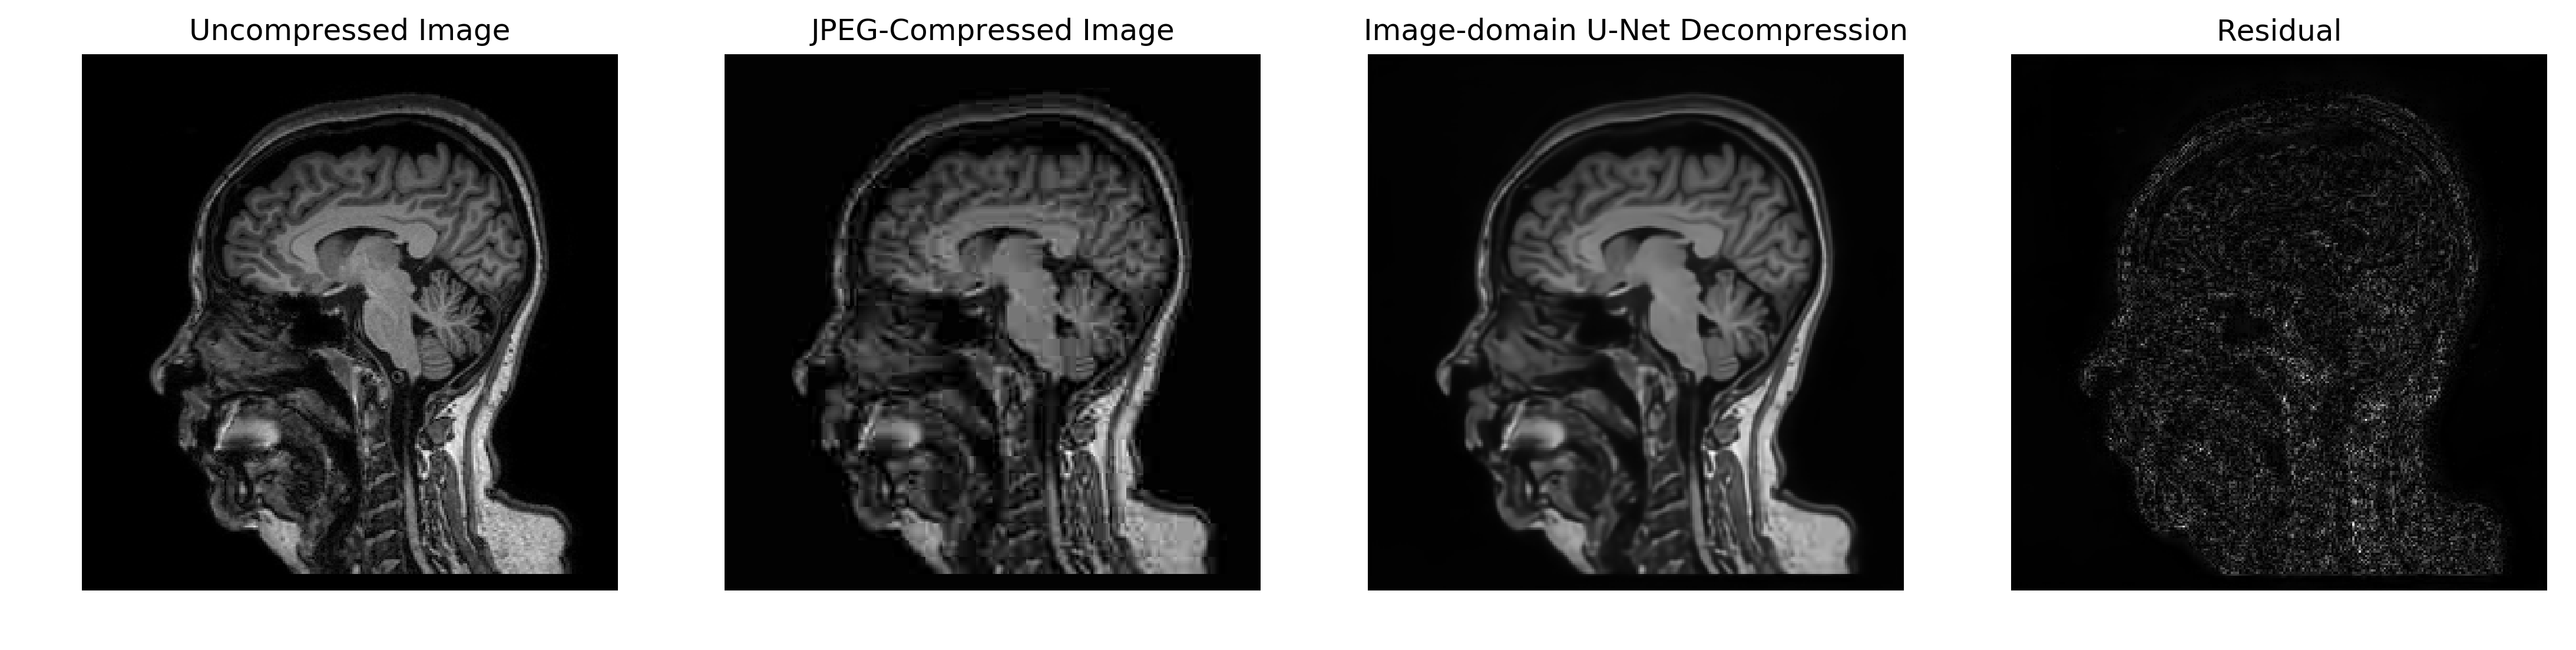

In [8]:
print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[slc,:,:,0]),np.max(pred[slc,:,:,0]))

plt.figure(figsize = (18,12),dpi=300)
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Image-domain U-Net Decompression")
plt.imshow(pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results


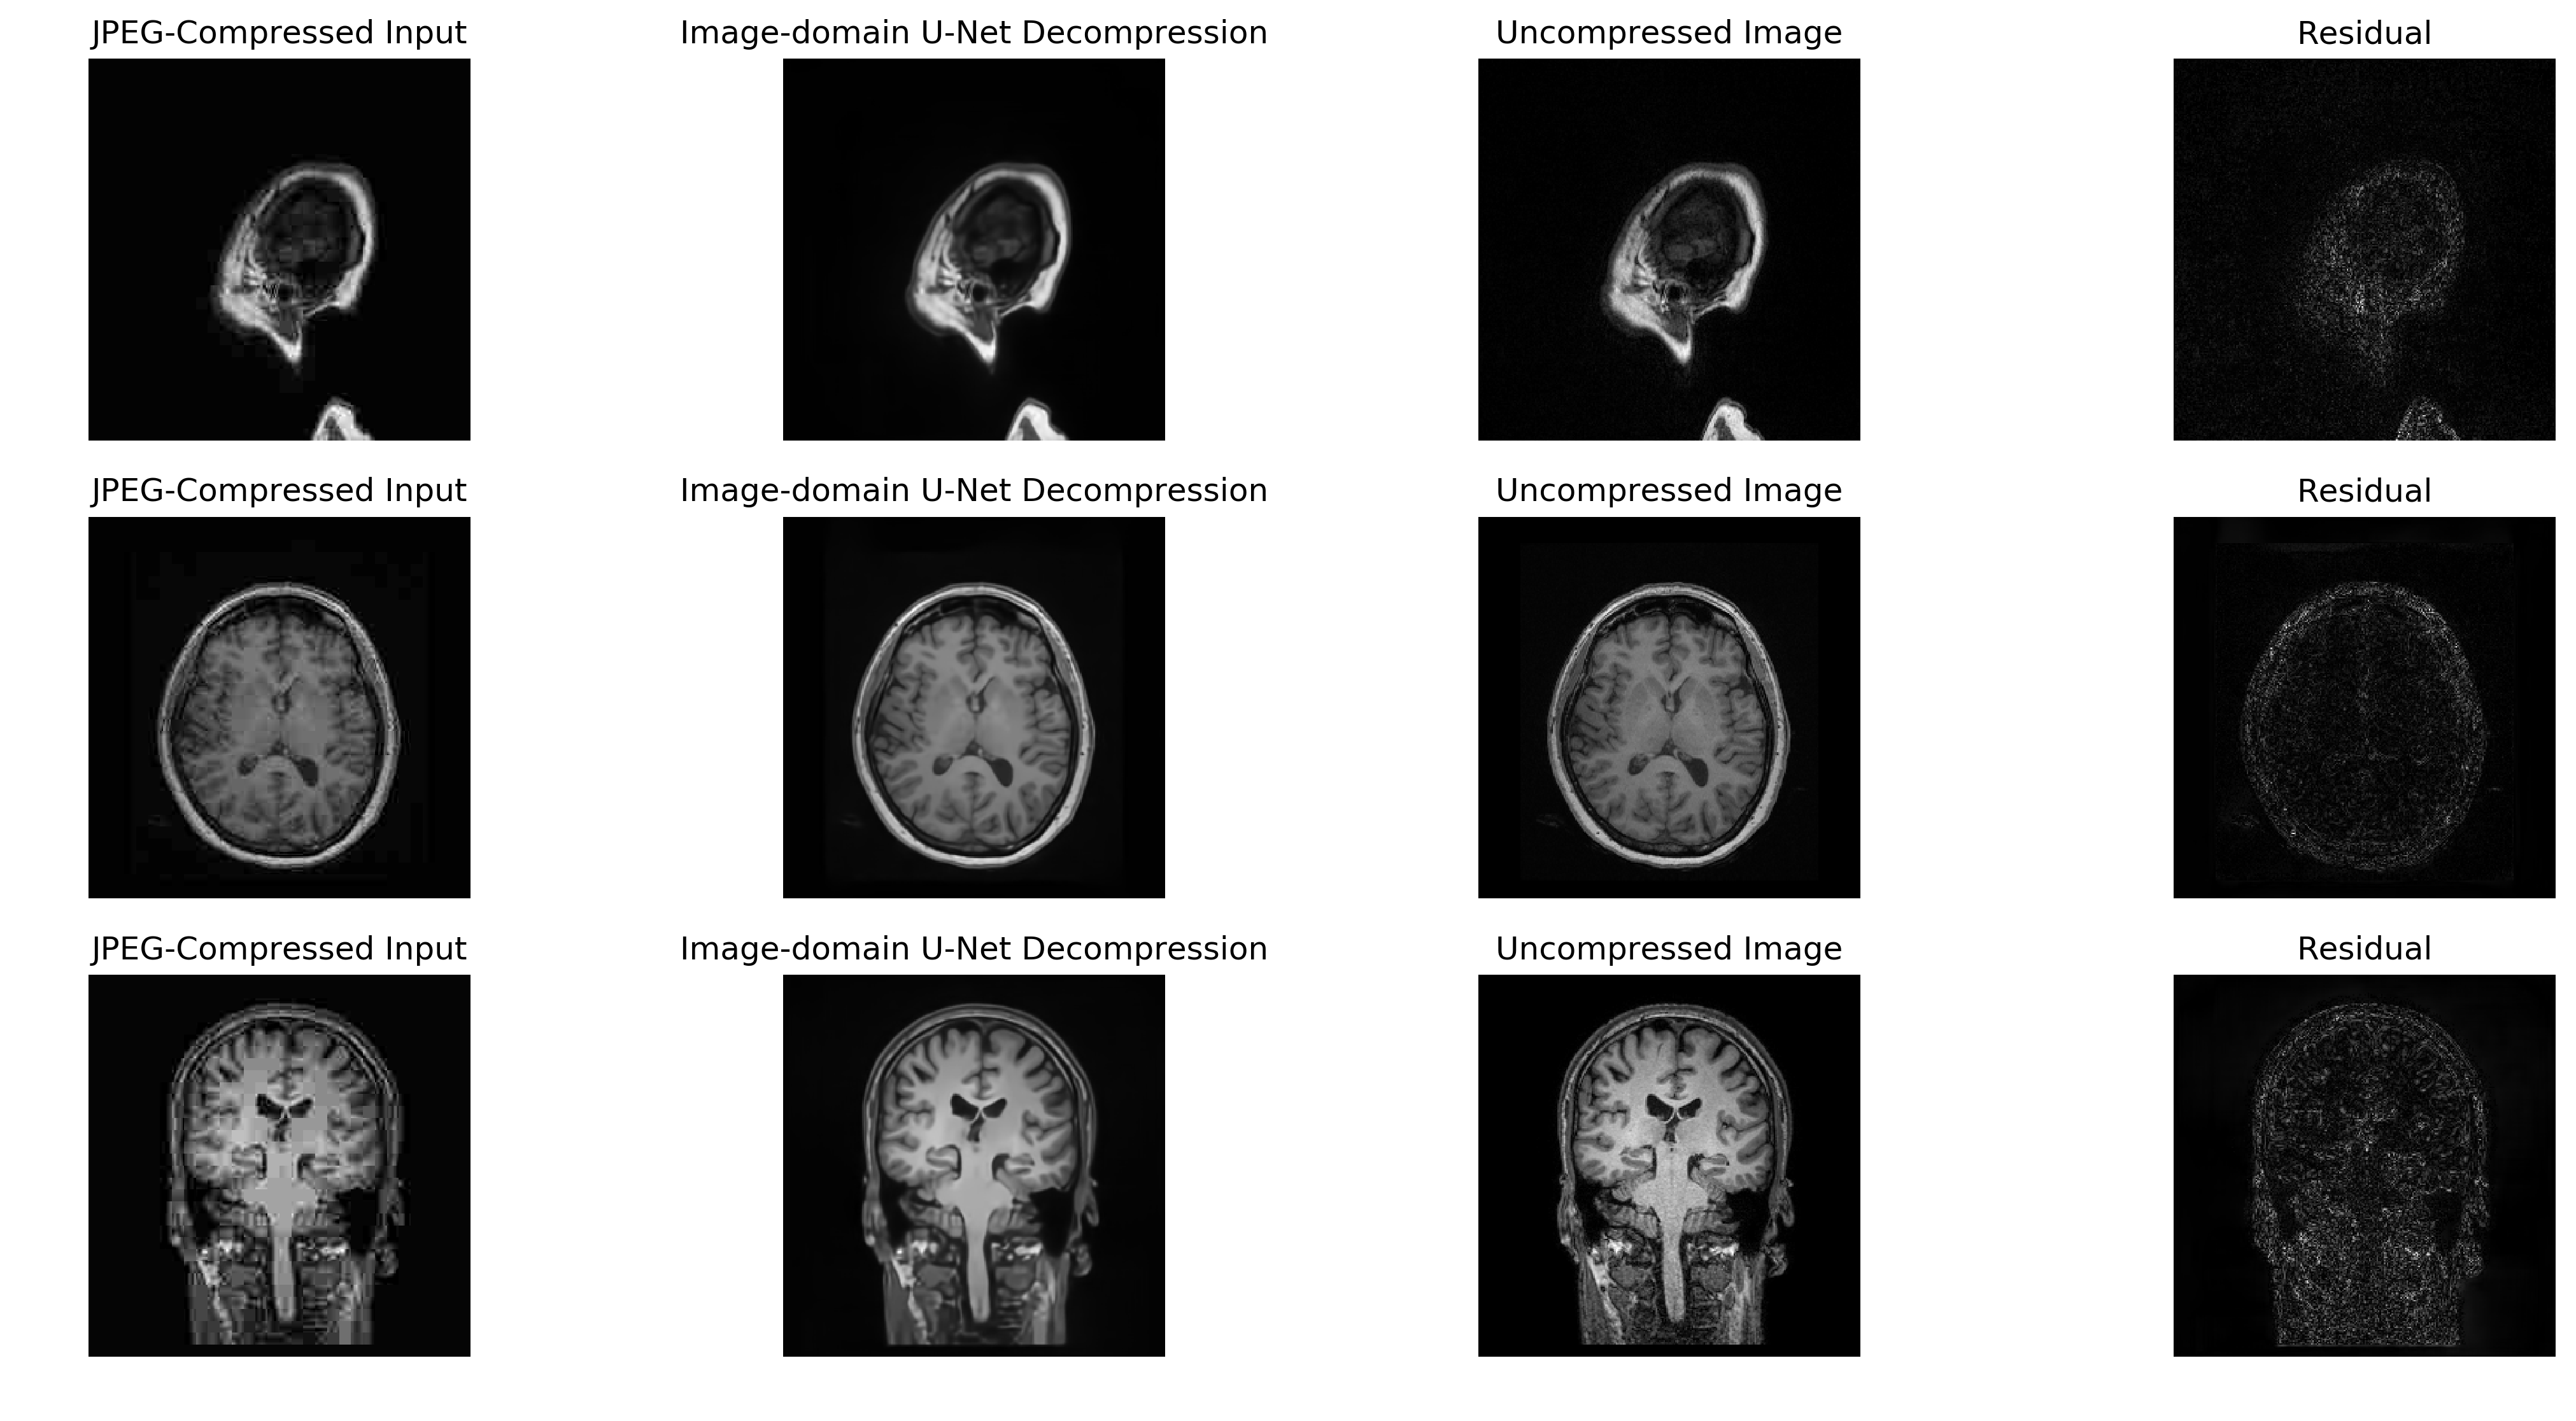

In [9]:
print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Input")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Image-domain U-Net Decompression")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0]-pred[indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

In [10]:
metr = calculate_metrics(test_unc, pred)

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


removing 1629 NRMSE from list.
removing 1715 NRMSE from list.
removing 1890 NRMSE from list.
removing 1896 NRMSE from list.
removing 3240 NRMSE from list.
removing 3514 NRMSE from list.
removing 3519 NRMSE from list.
(16103, 3, 2)

Performance Metrics
SSIM: 0.840 +/- 0.060
PSNR: 31.034 +/- 1.666
NRMSE: 2.687 +/- 0.474


# Network 2: DCT-domain U-net

In [11]:
opt=Adam(lr=0.0001)
model_name = "../Models/20190325-pretrained-residual_unet_d_data_augmentation_compress_10_20.hdf5"
model=my_unet()
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

In [12]:
dct_pred = model.predict(dct_test_compr)

In [13]:
if useBlocks:
    for ii in range(len(test_images)):
        pred[ii,:,:,0] = idct_in_blocks(dct_pred[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        pred[ii,:,:,0] = py_idct2d(dct_pred[ii,:,:,0])
        
pred *= 128.0
pred += 128.0

0.0 169.0
-2.7217407 186.84679


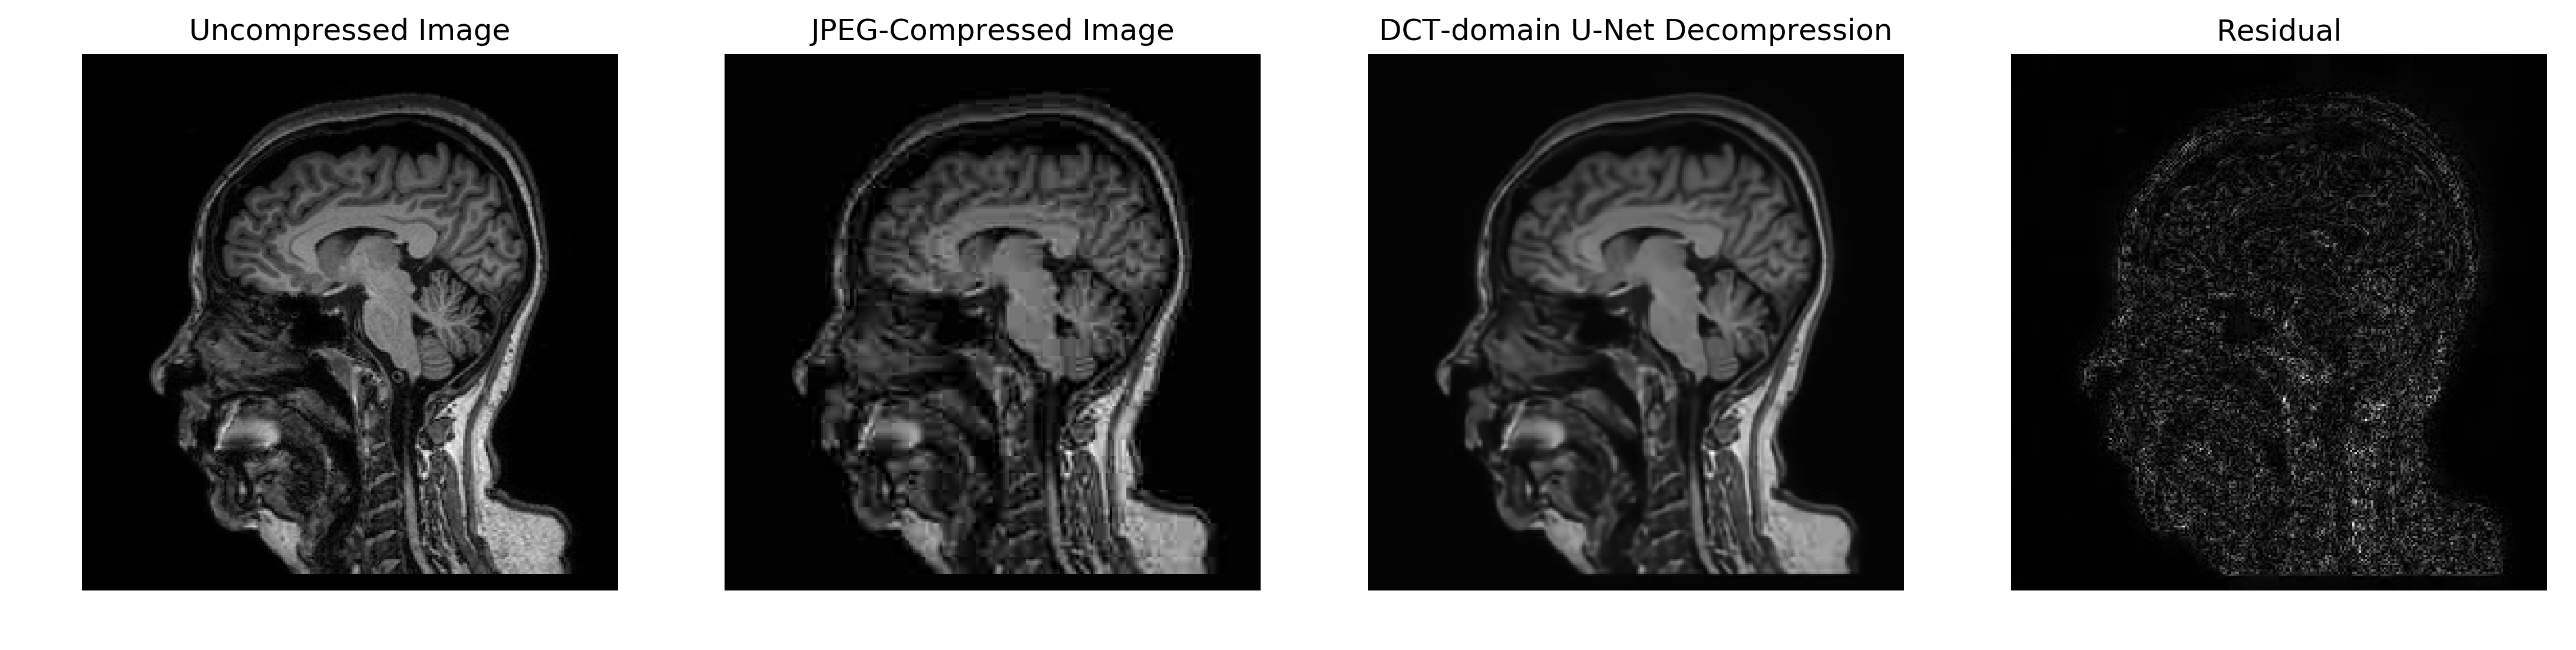

In [14]:
print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[slc,:,:,0]),np.max(pred[slc,:,:,0]))

plt.figure(figsize = (18,12),dpi=300)
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("DCT-domain U-Net Decompression")
plt.imshow(pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results


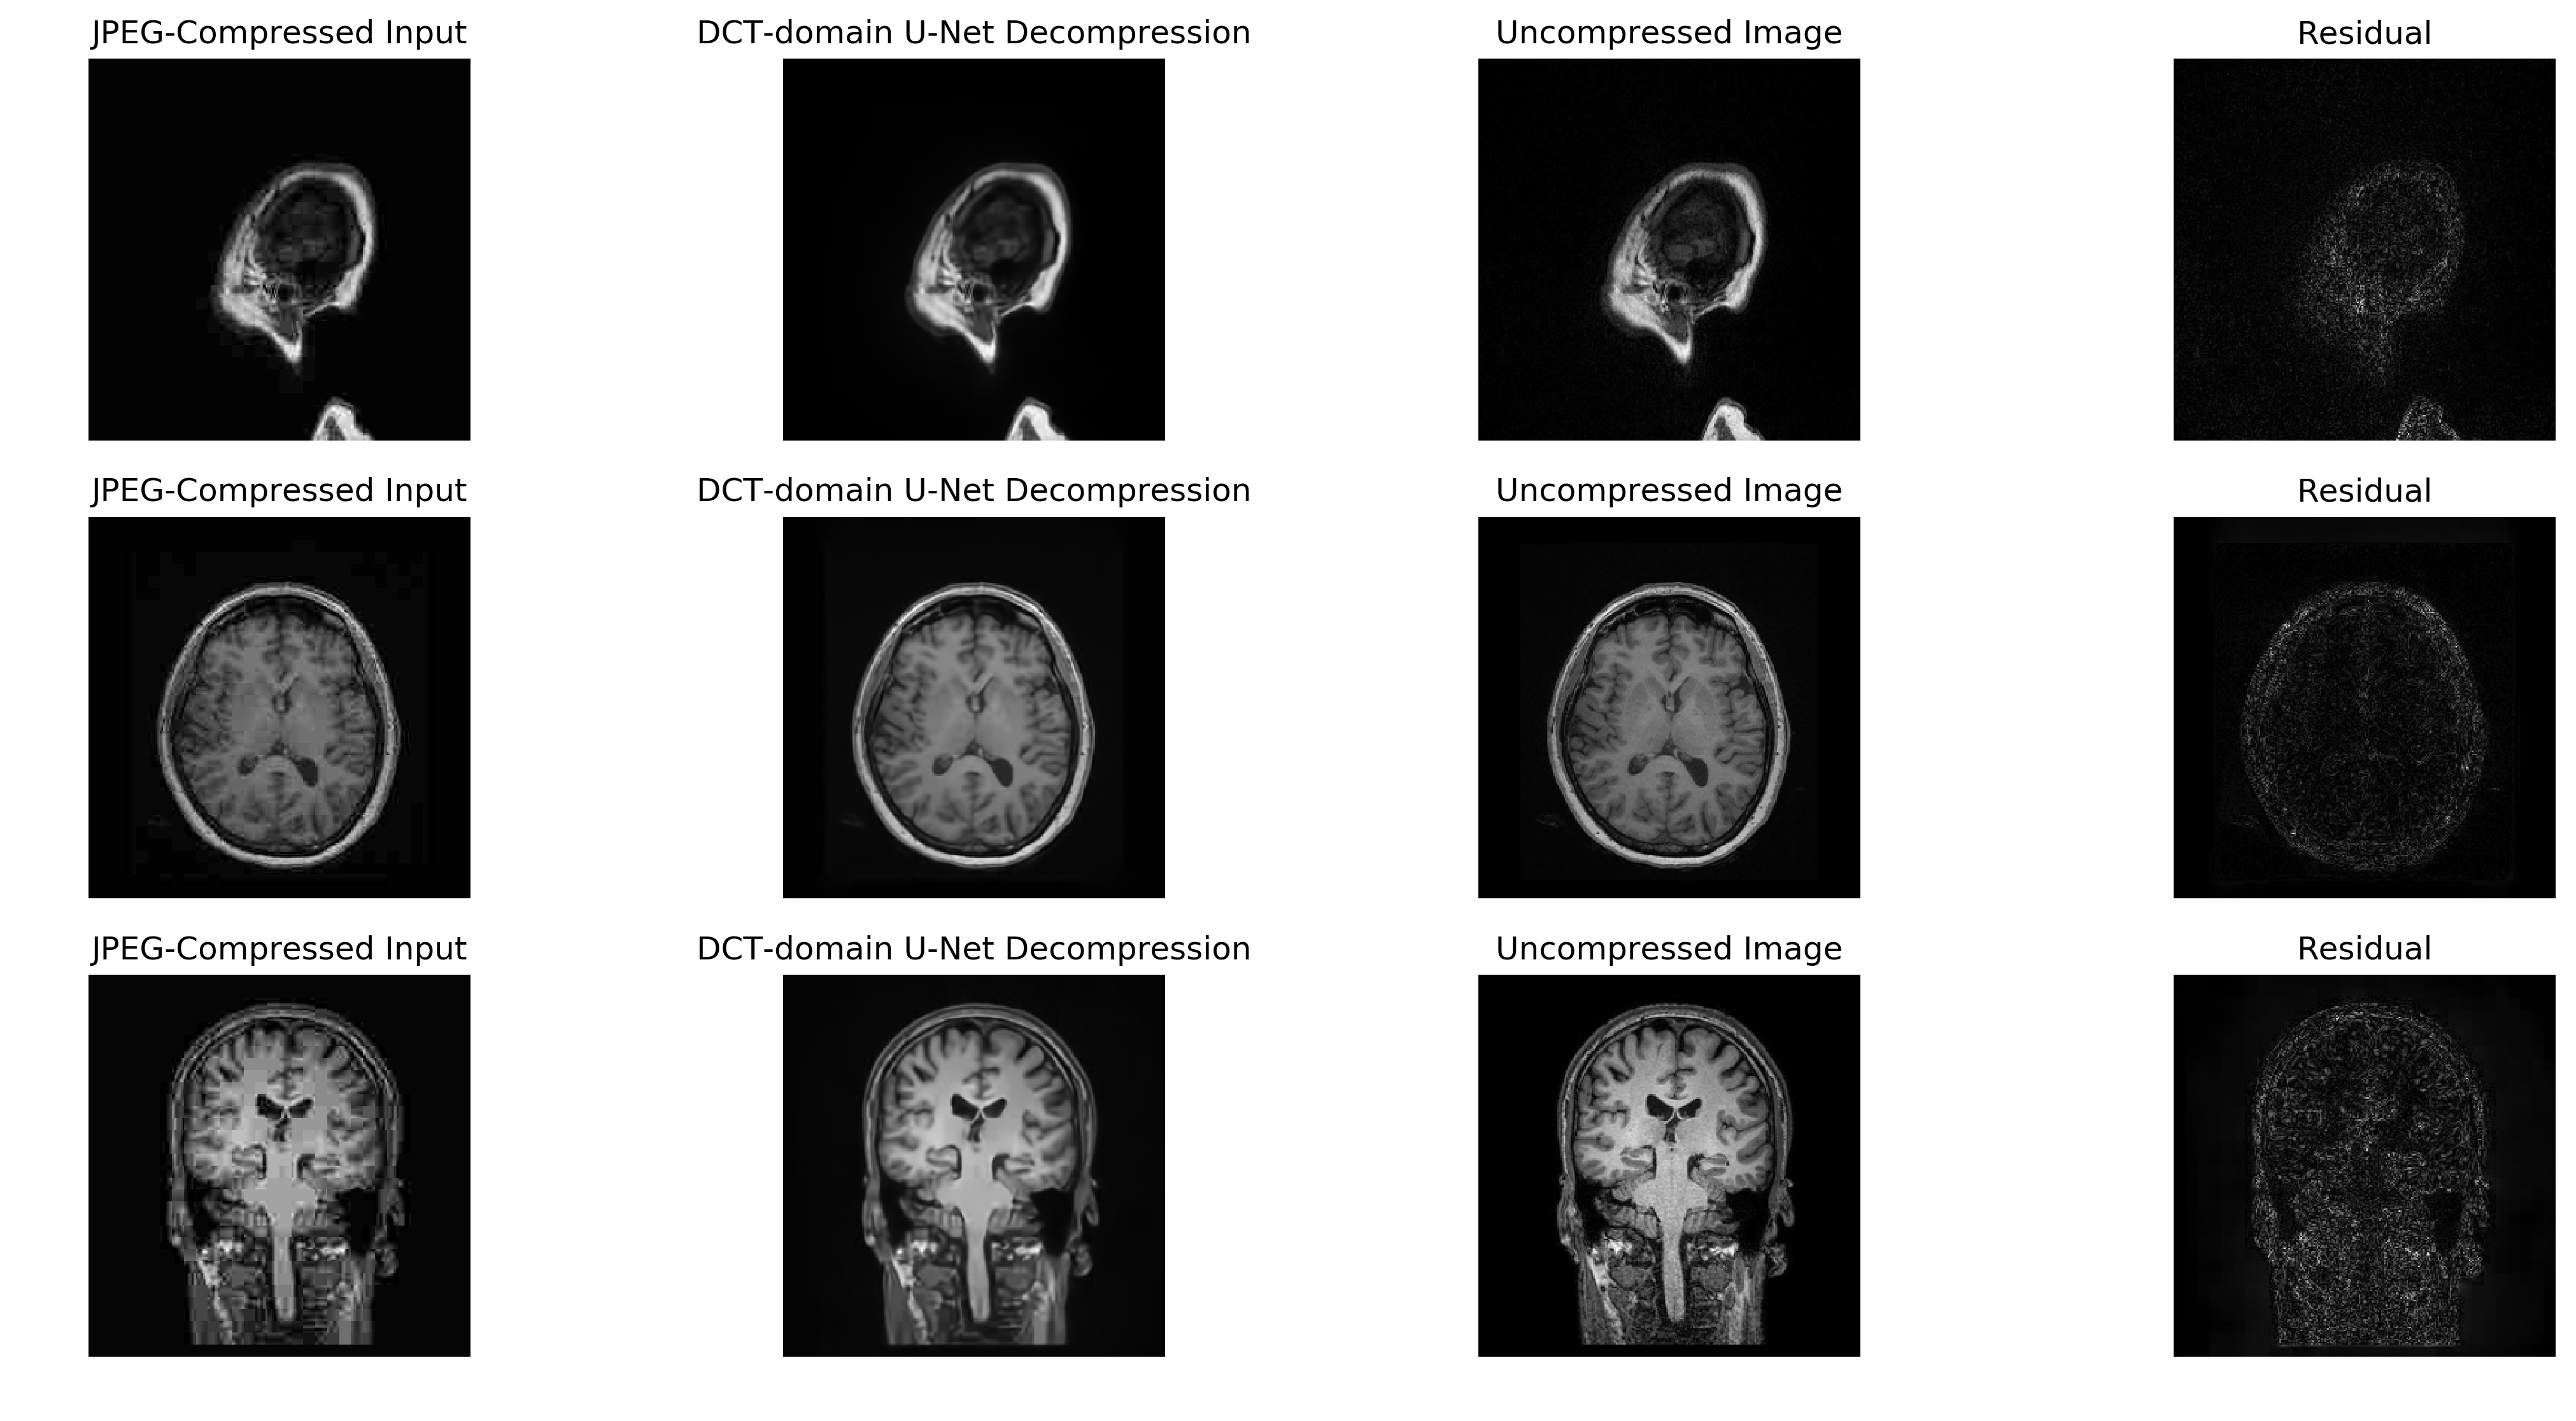

In [15]:
print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Input")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("DCT-domain U-Net Decompression")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0]-pred[indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

In [16]:
metr = calculate_metrics(test_unc, pred)

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


removing 1629 NRMSE from list.
removing 1715 NRMSE from list.
removing 1890 NRMSE from list.
removing 1896 NRMSE from list.
removing 3240 NRMSE from list.
removing 3514 NRMSE from list.
removing 3519 NRMSE from list.
(16103, 3, 2)

Performance Metrics
SSIM: 0.860 +/- 0.050
PSNR: 31.130 +/- 1.686
NRMSE: 2.720 +/- 0.481


# Network 3: DCT-Image-domain "Pseudo" W-net

In [17]:
opt=Adam(lr=0.0001)
model_name = "../Models/20190325-pretrained-residual_pseudo_wnet_di_data_augmentation_compress_10_20-float.hdf5"
model=deep_cascade_unet_no_dc(depth_str='i')
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

0 i
Append U-net block


In [18]:
pred -= 128.0
pred /= 128.0

pred = model.predict(pred) # For the pseudo W-net, use output from network 2 as input to model

pred *= 128.0
pred += 128.0

0.0 169.0
-1.5935822 182.9868


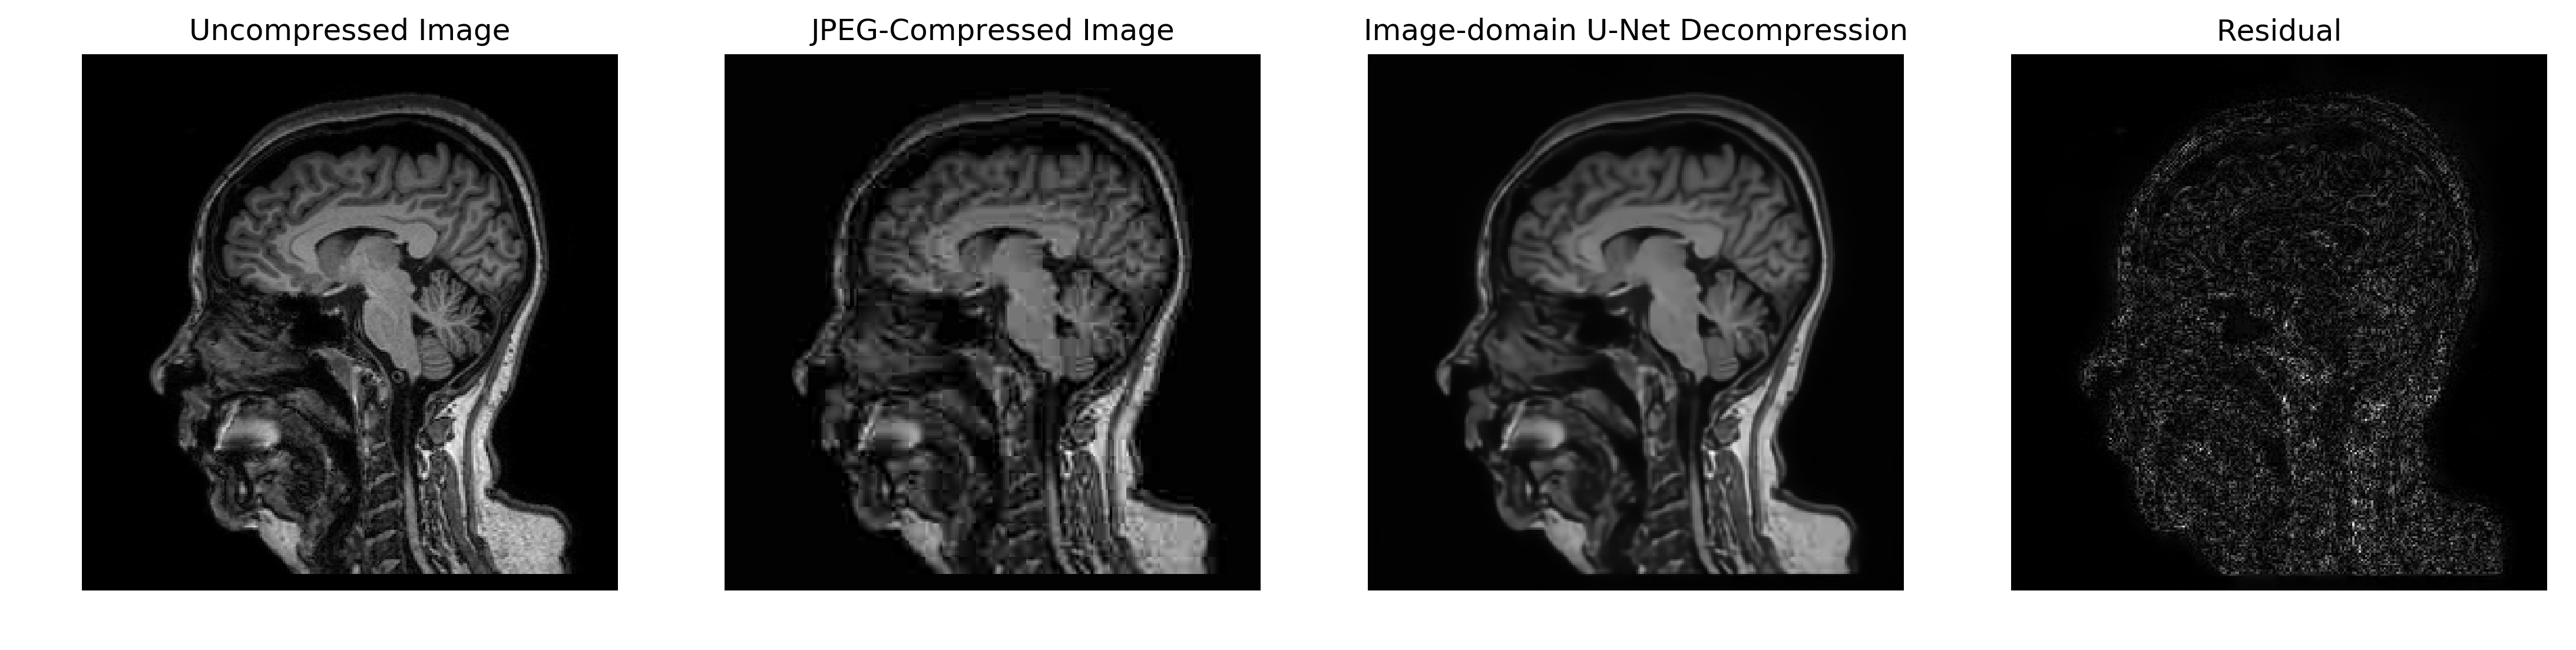

In [19]:
print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[slc,:,:,0]),np.max(pred[slc,:,:,0]))

plt.figure(figsize = (18,12),dpi=300)
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Image-domain U-Net Decompression")
plt.imshow(pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results


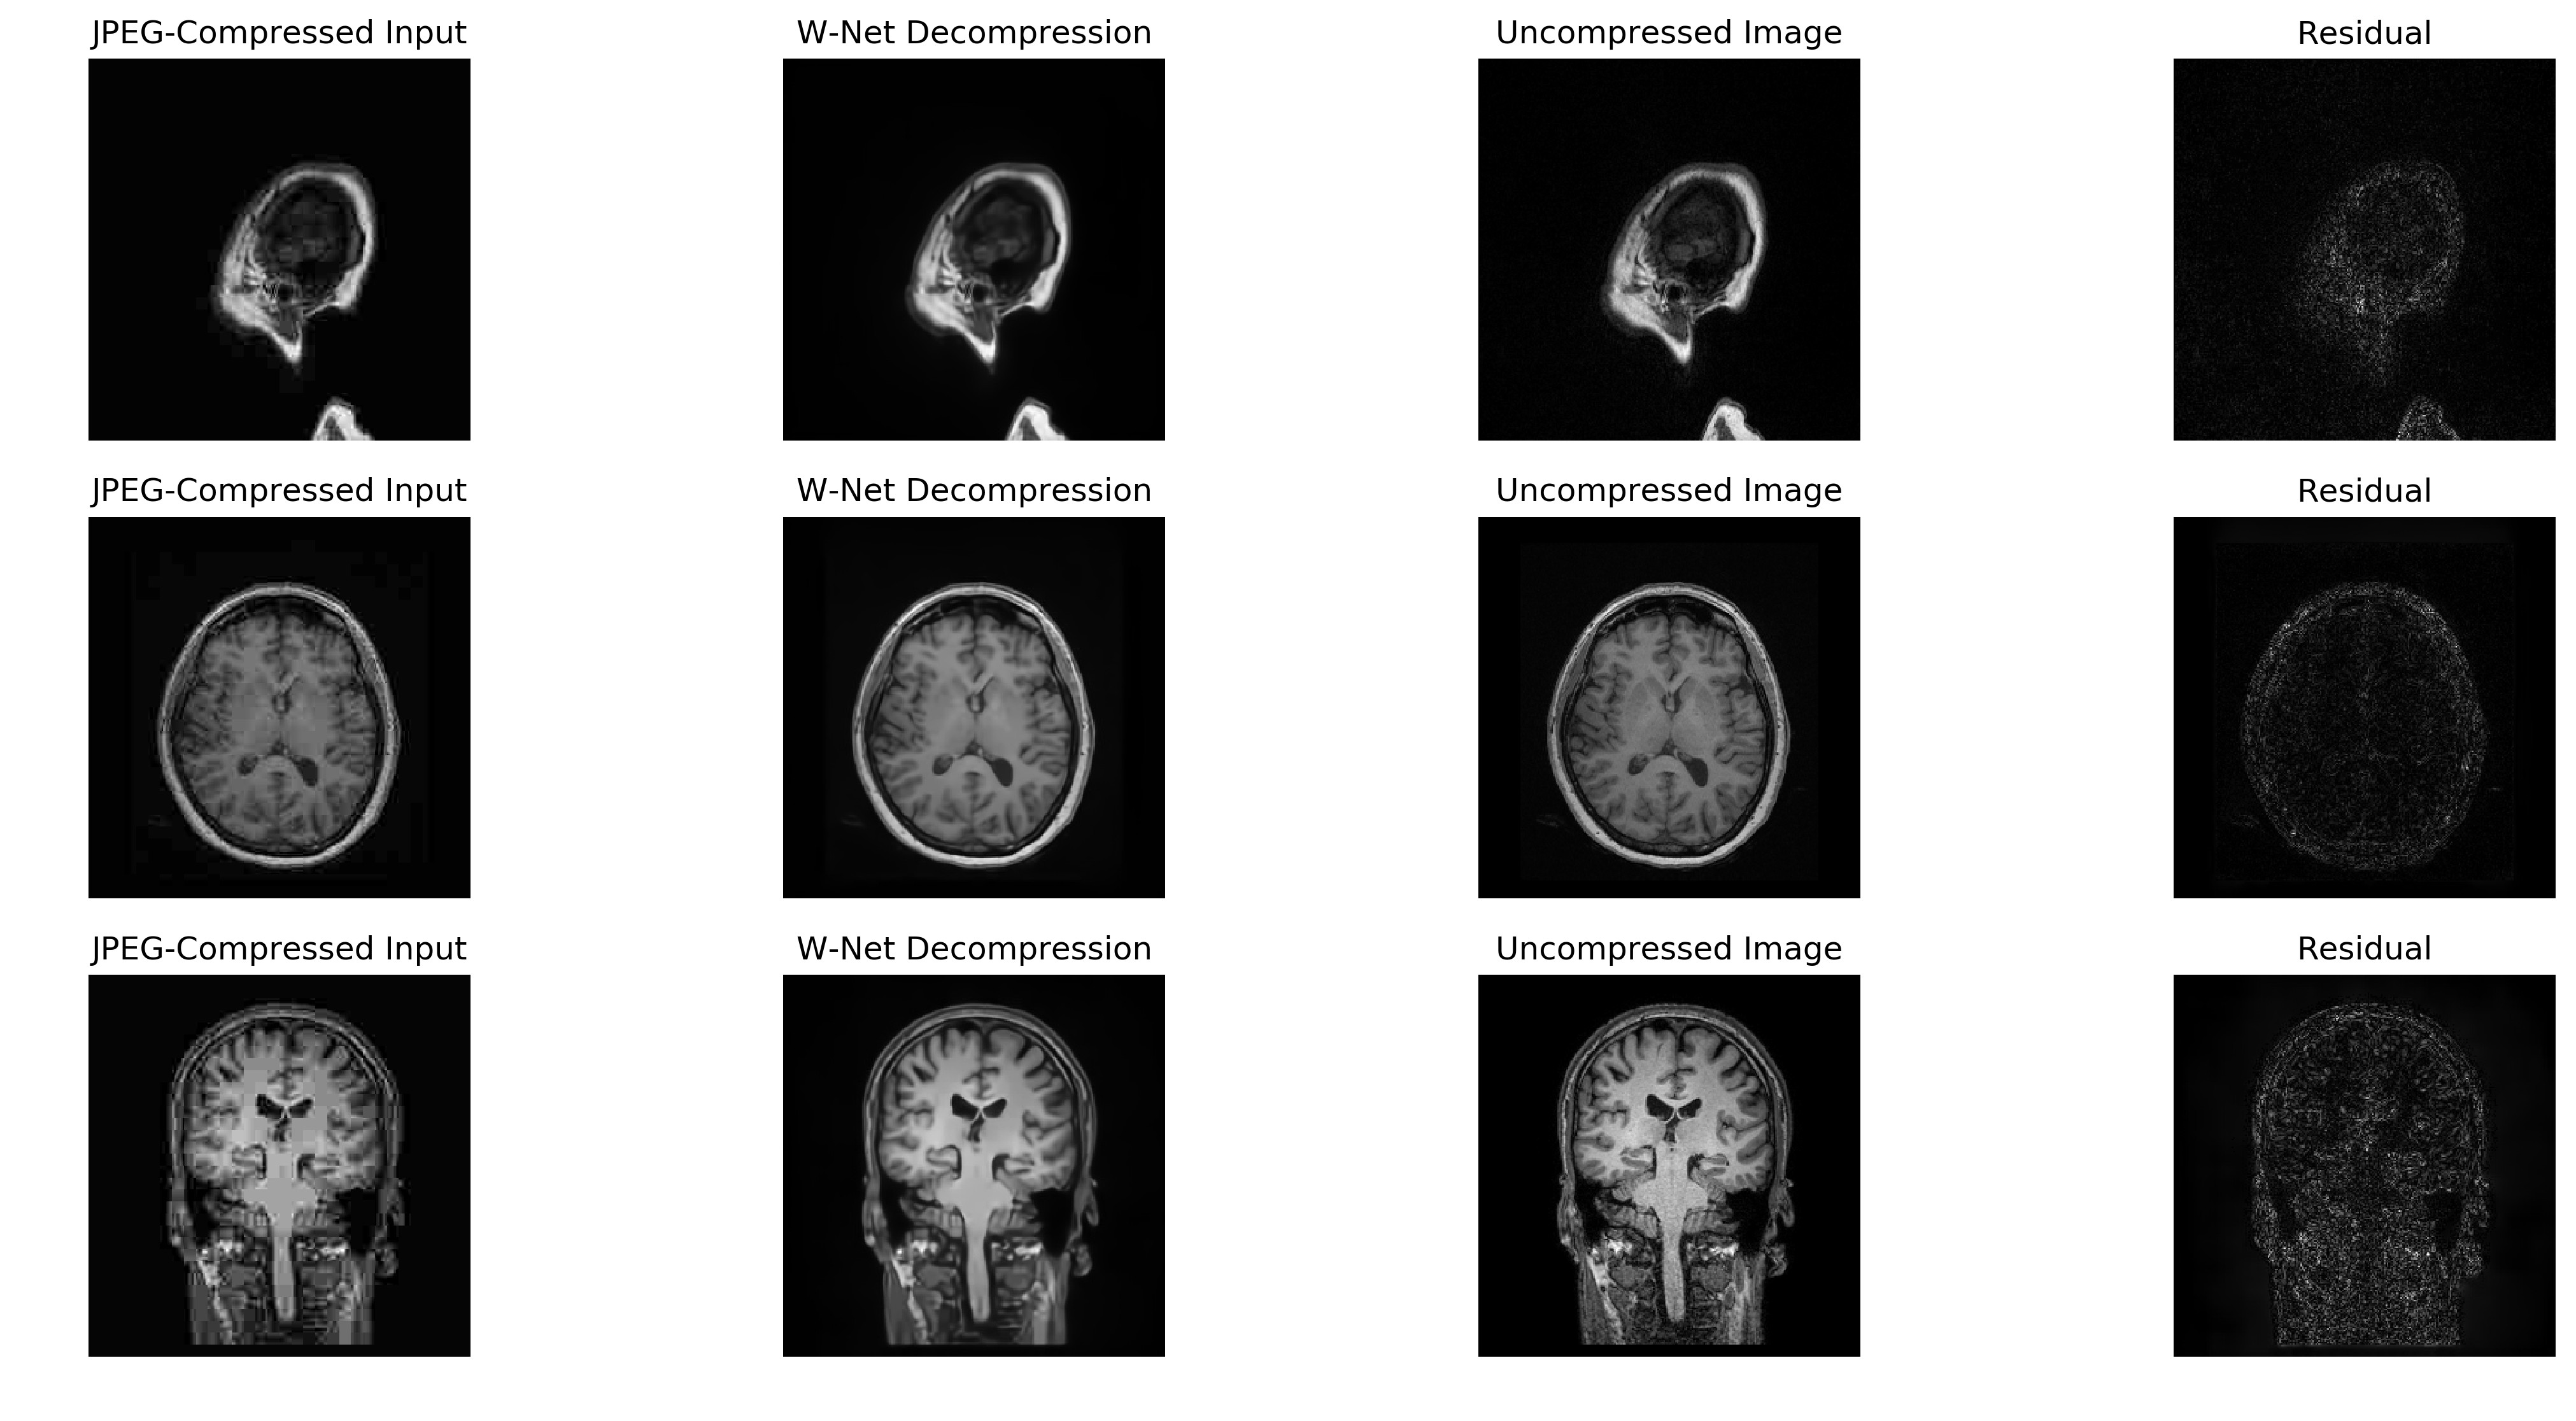

In [20]:
print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Input")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("W-Net Decompression")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0]-pred[indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

In [21]:
metr = calculate_metrics(test_unc, pred)

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


removing 1629 NRMSE from list.
removing 1715 NRMSE from list.
removing 1890 NRMSE from list.
removing 1896 NRMSE from list.
removing 3240 NRMSE from list.
removing 3514 NRMSE from list.
removing 3519 NRMSE from list.
(16103, 3, 2)

Performance Metrics
SSIM: 0.860 +/- 0.051
PSNR: 30.981 +/- 1.675
NRMSE: 2.705 +/- 0.479


# Network 4: Image-Image-domain W-net

In [22]:
opt=Adam(lr=0.0001)
model_name = "../Models/20190327-pretrained-residual_wnet_ii_data_augmentation_compress_10_20.hdf5"
model=deep_cascade_unet_no_dc(depth_str='ii')
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

0 i
Append U-net block
1 i
Append U-net block


In [23]:
pred = model.predict(norm_test_compr)

pred *= 128.0
pred += 128.0

0.0 169.0
-2.7690277 172.2337


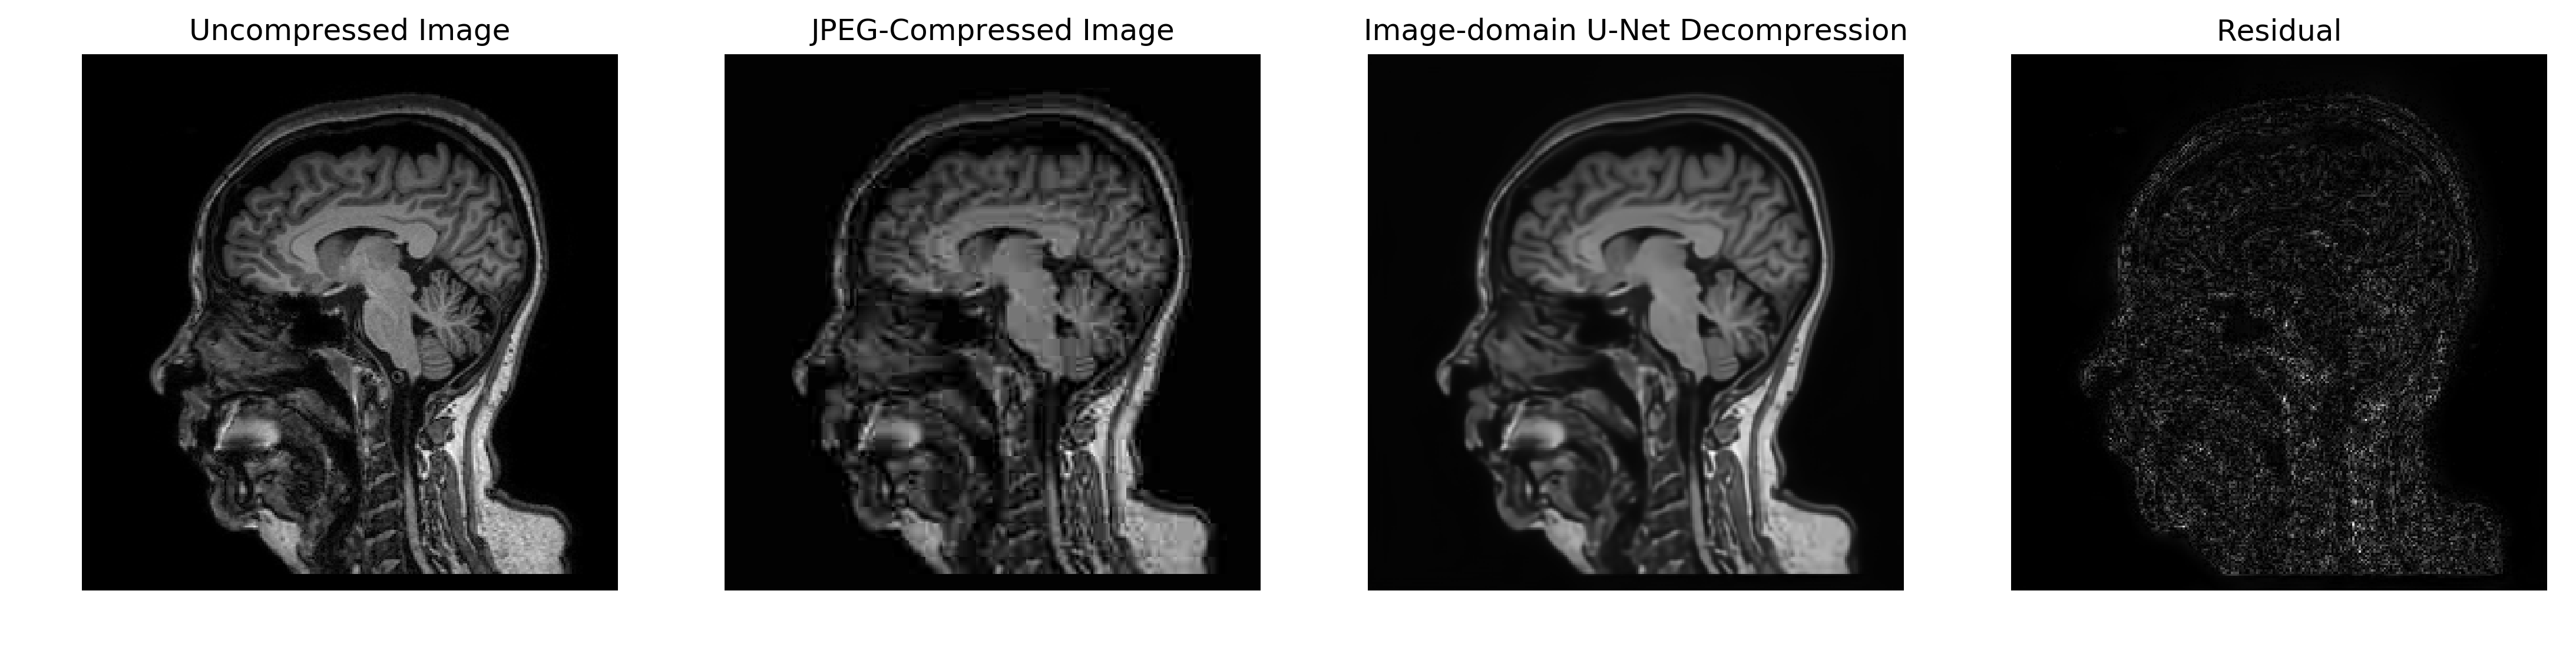

In [24]:
print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[slc,:,:,0]),np.max(pred[slc,:,:,0]))

plt.figure(figsize = (18,12),dpi=300)
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Image-domain U-Net Decompression")
plt.imshow(pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results


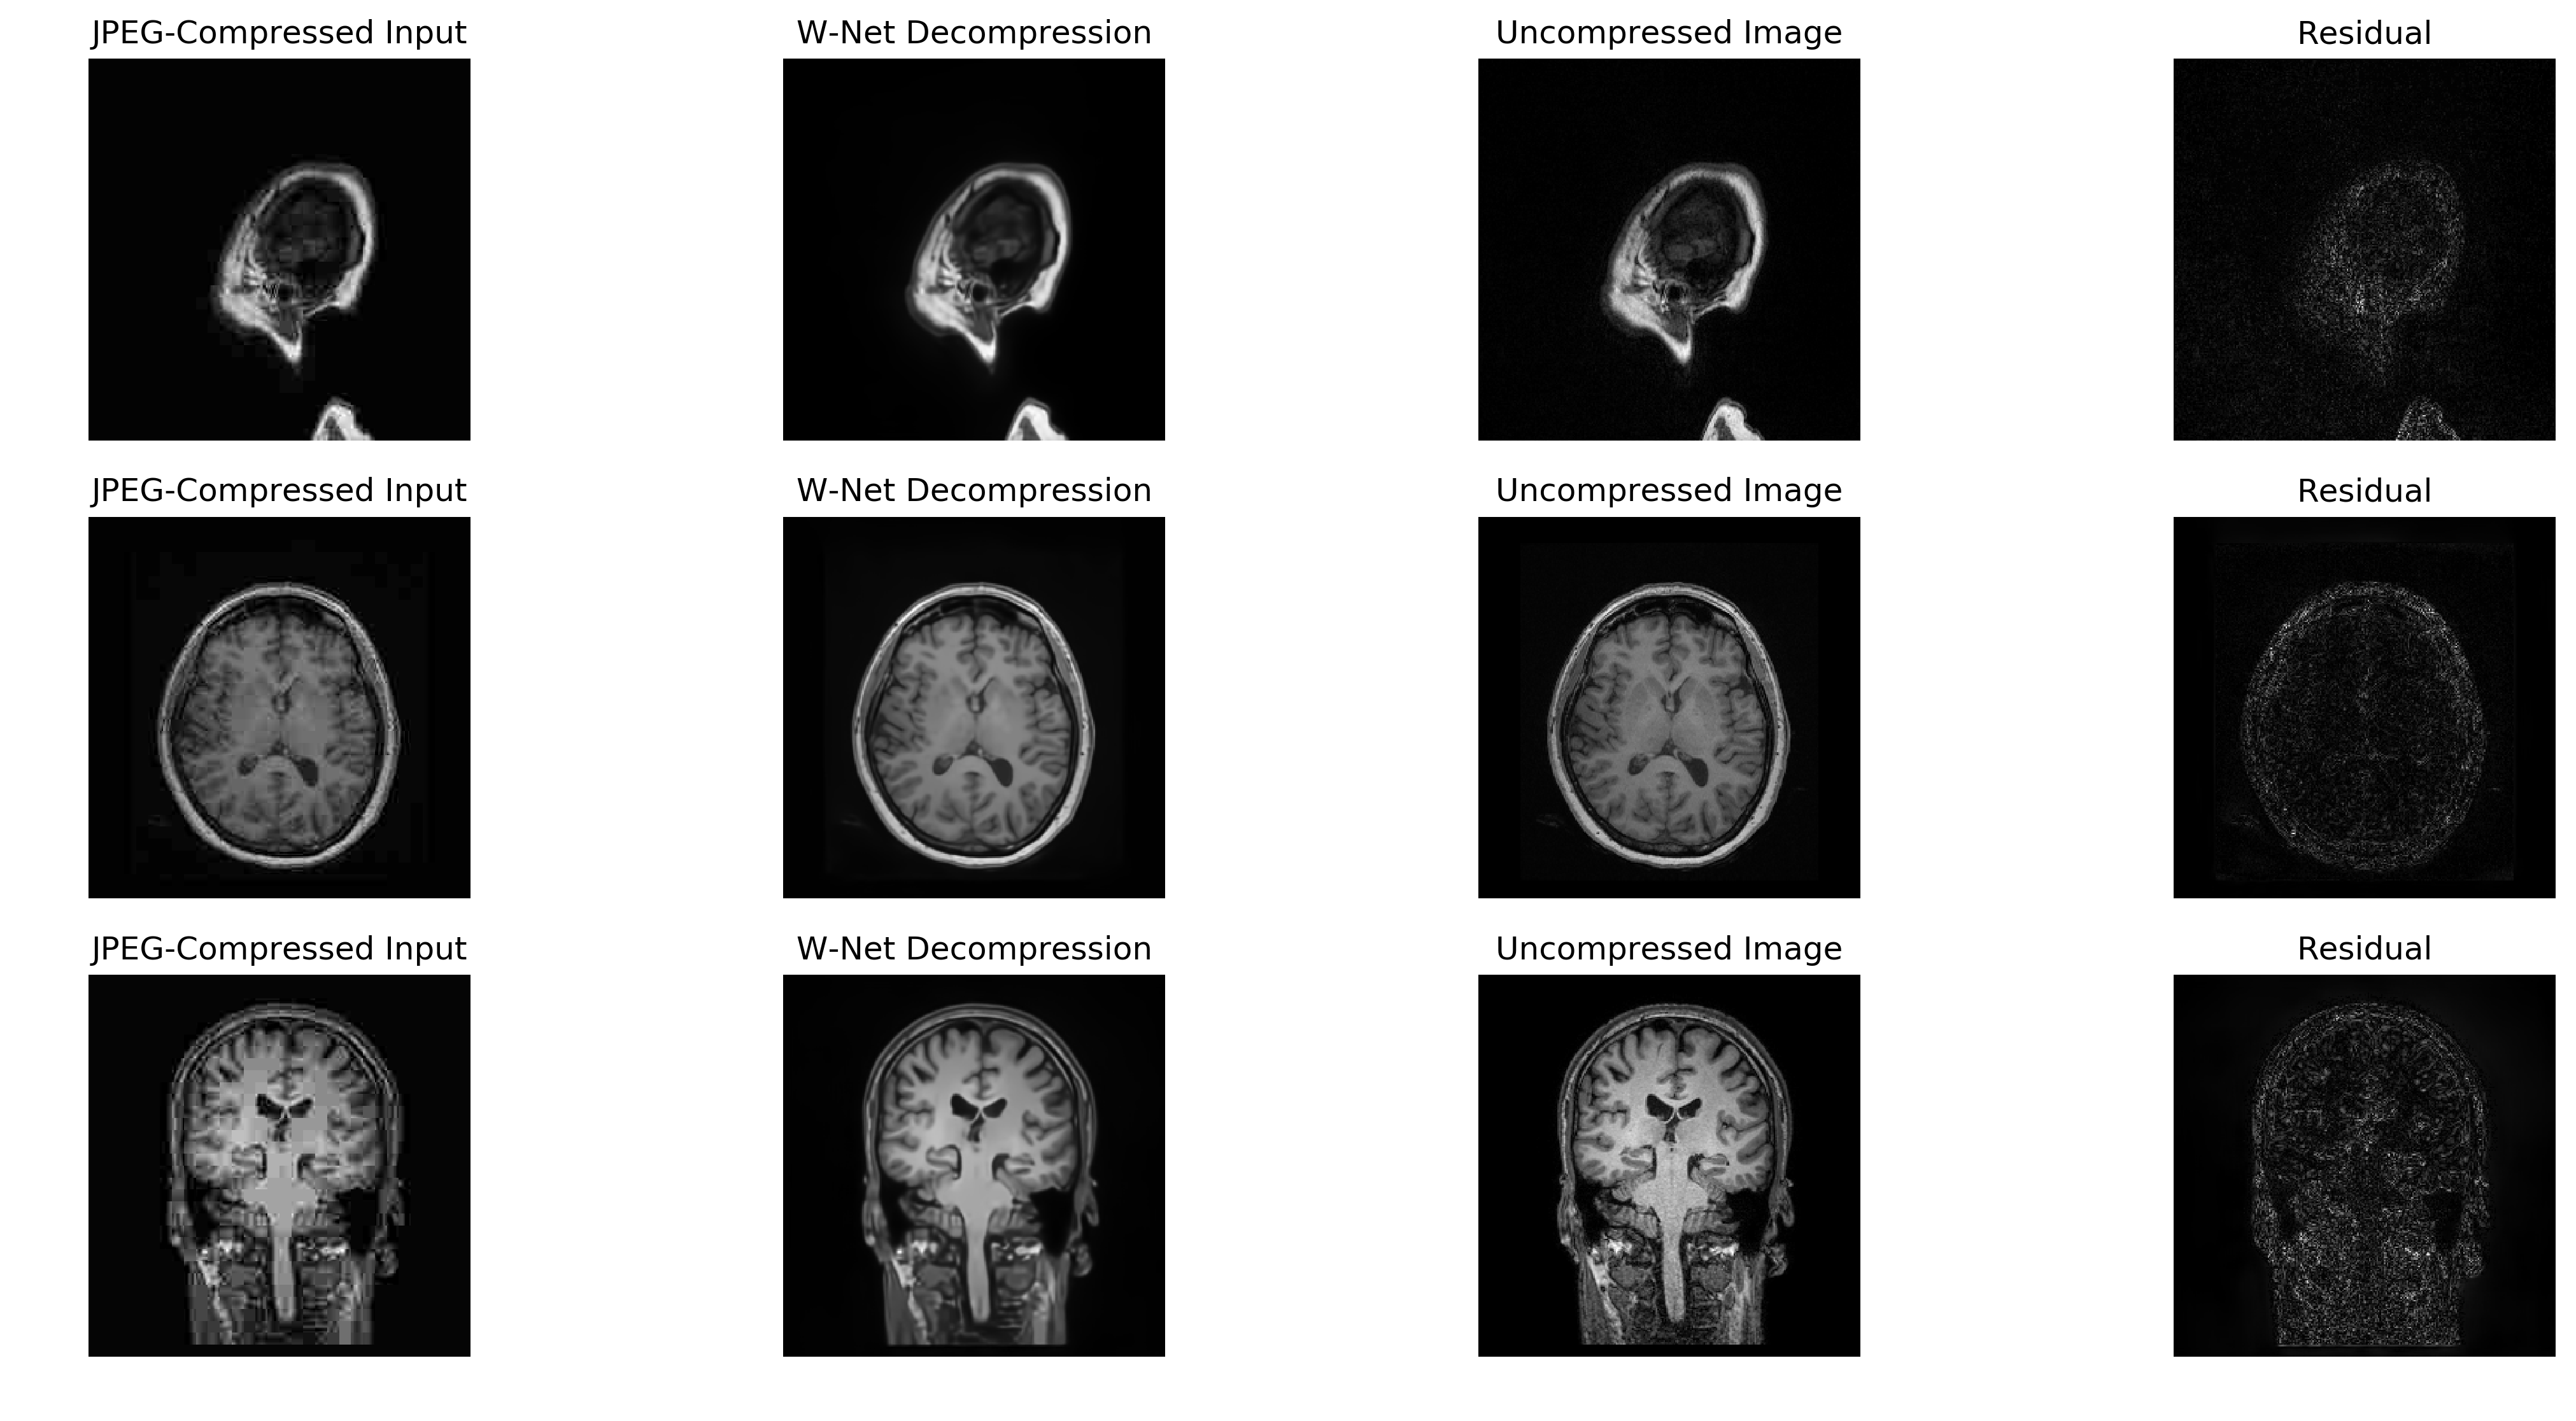

In [25]:
print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Input")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("W-Net Decompression")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0]-pred[indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

In [26]:
metr = calculate_metrics(test_unc, pred)

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


removing 1629 NRMSE from list.
removing 1715 NRMSE from list.
removing 1890 NRMSE from list.
removing 1896 NRMSE from list.
removing 3240 NRMSE from list.
removing 3514 NRMSE from list.
removing 3519 NRMSE from list.
(16103, 3, 2)

Performance Metrics
SSIM: 0.854 +/- 0.060
PSNR: 31.070 +/- 1.685
NRMSE: 2.675 +/- 0.475


# Network 5: DCT-DCT-domain W-net

In [27]:
opt=Adam(lr=0.0001)
model_name = "../Models/20190326-pretrained-residual_wnet_py_dd_data_augmentation_compress_10_20.hdf5"
model=deep_cascade_unet_no_dc(depth_str='ii') # doing DCT outside of network so use 'ii'
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

0 i
Append U-net block
1 i
Append U-net block


In [28]:
dct_pred = model.predict(dct_test_compr)

In [29]:
if useBlocks:
    for ii in range(len(test_images)):
        pred[ii,:,:,0] = idct_in_blocks(dct_pred[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        pred[ii,:,:,0] = py_idct2d(dct_pred[ii,:,:,0])
        
pred *= 128.0
pred += 128.0

0.0 169.0
-2.2931213 184.37216


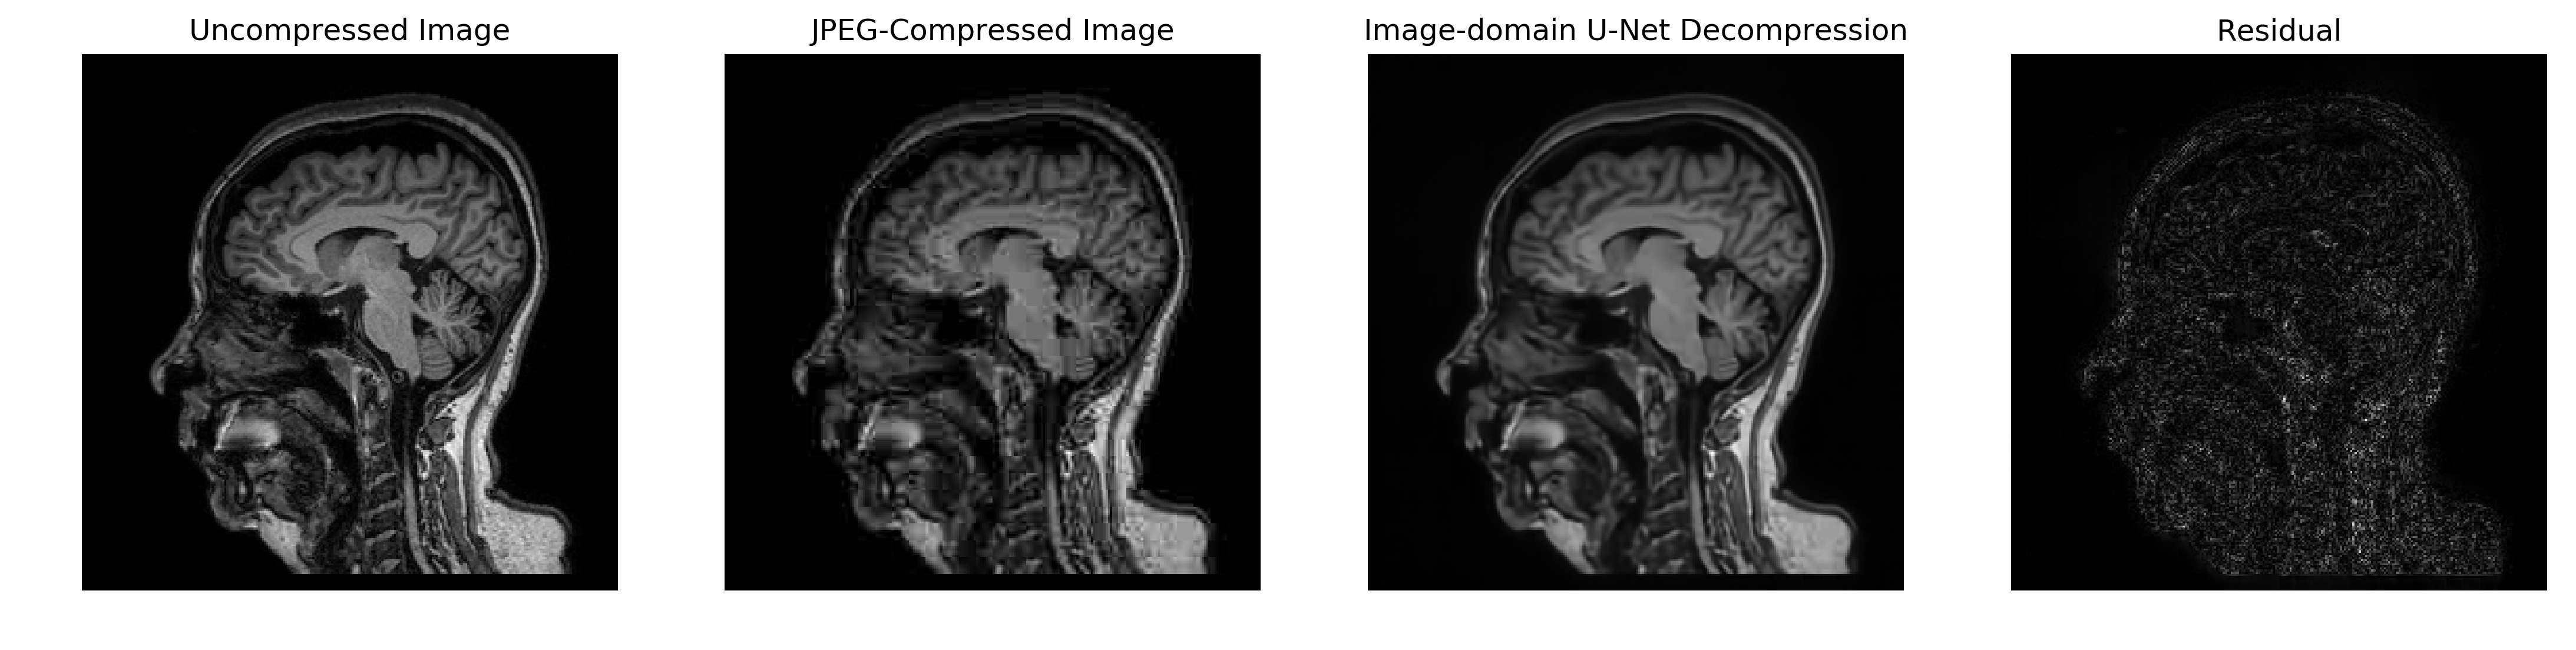

In [30]:
print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[slc,:,:,0]),np.max(pred[slc,:,:,0]))

plt.figure(figsize = (18,12),dpi=300)
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Image-domain U-Net Decompression")
plt.imshow(pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results


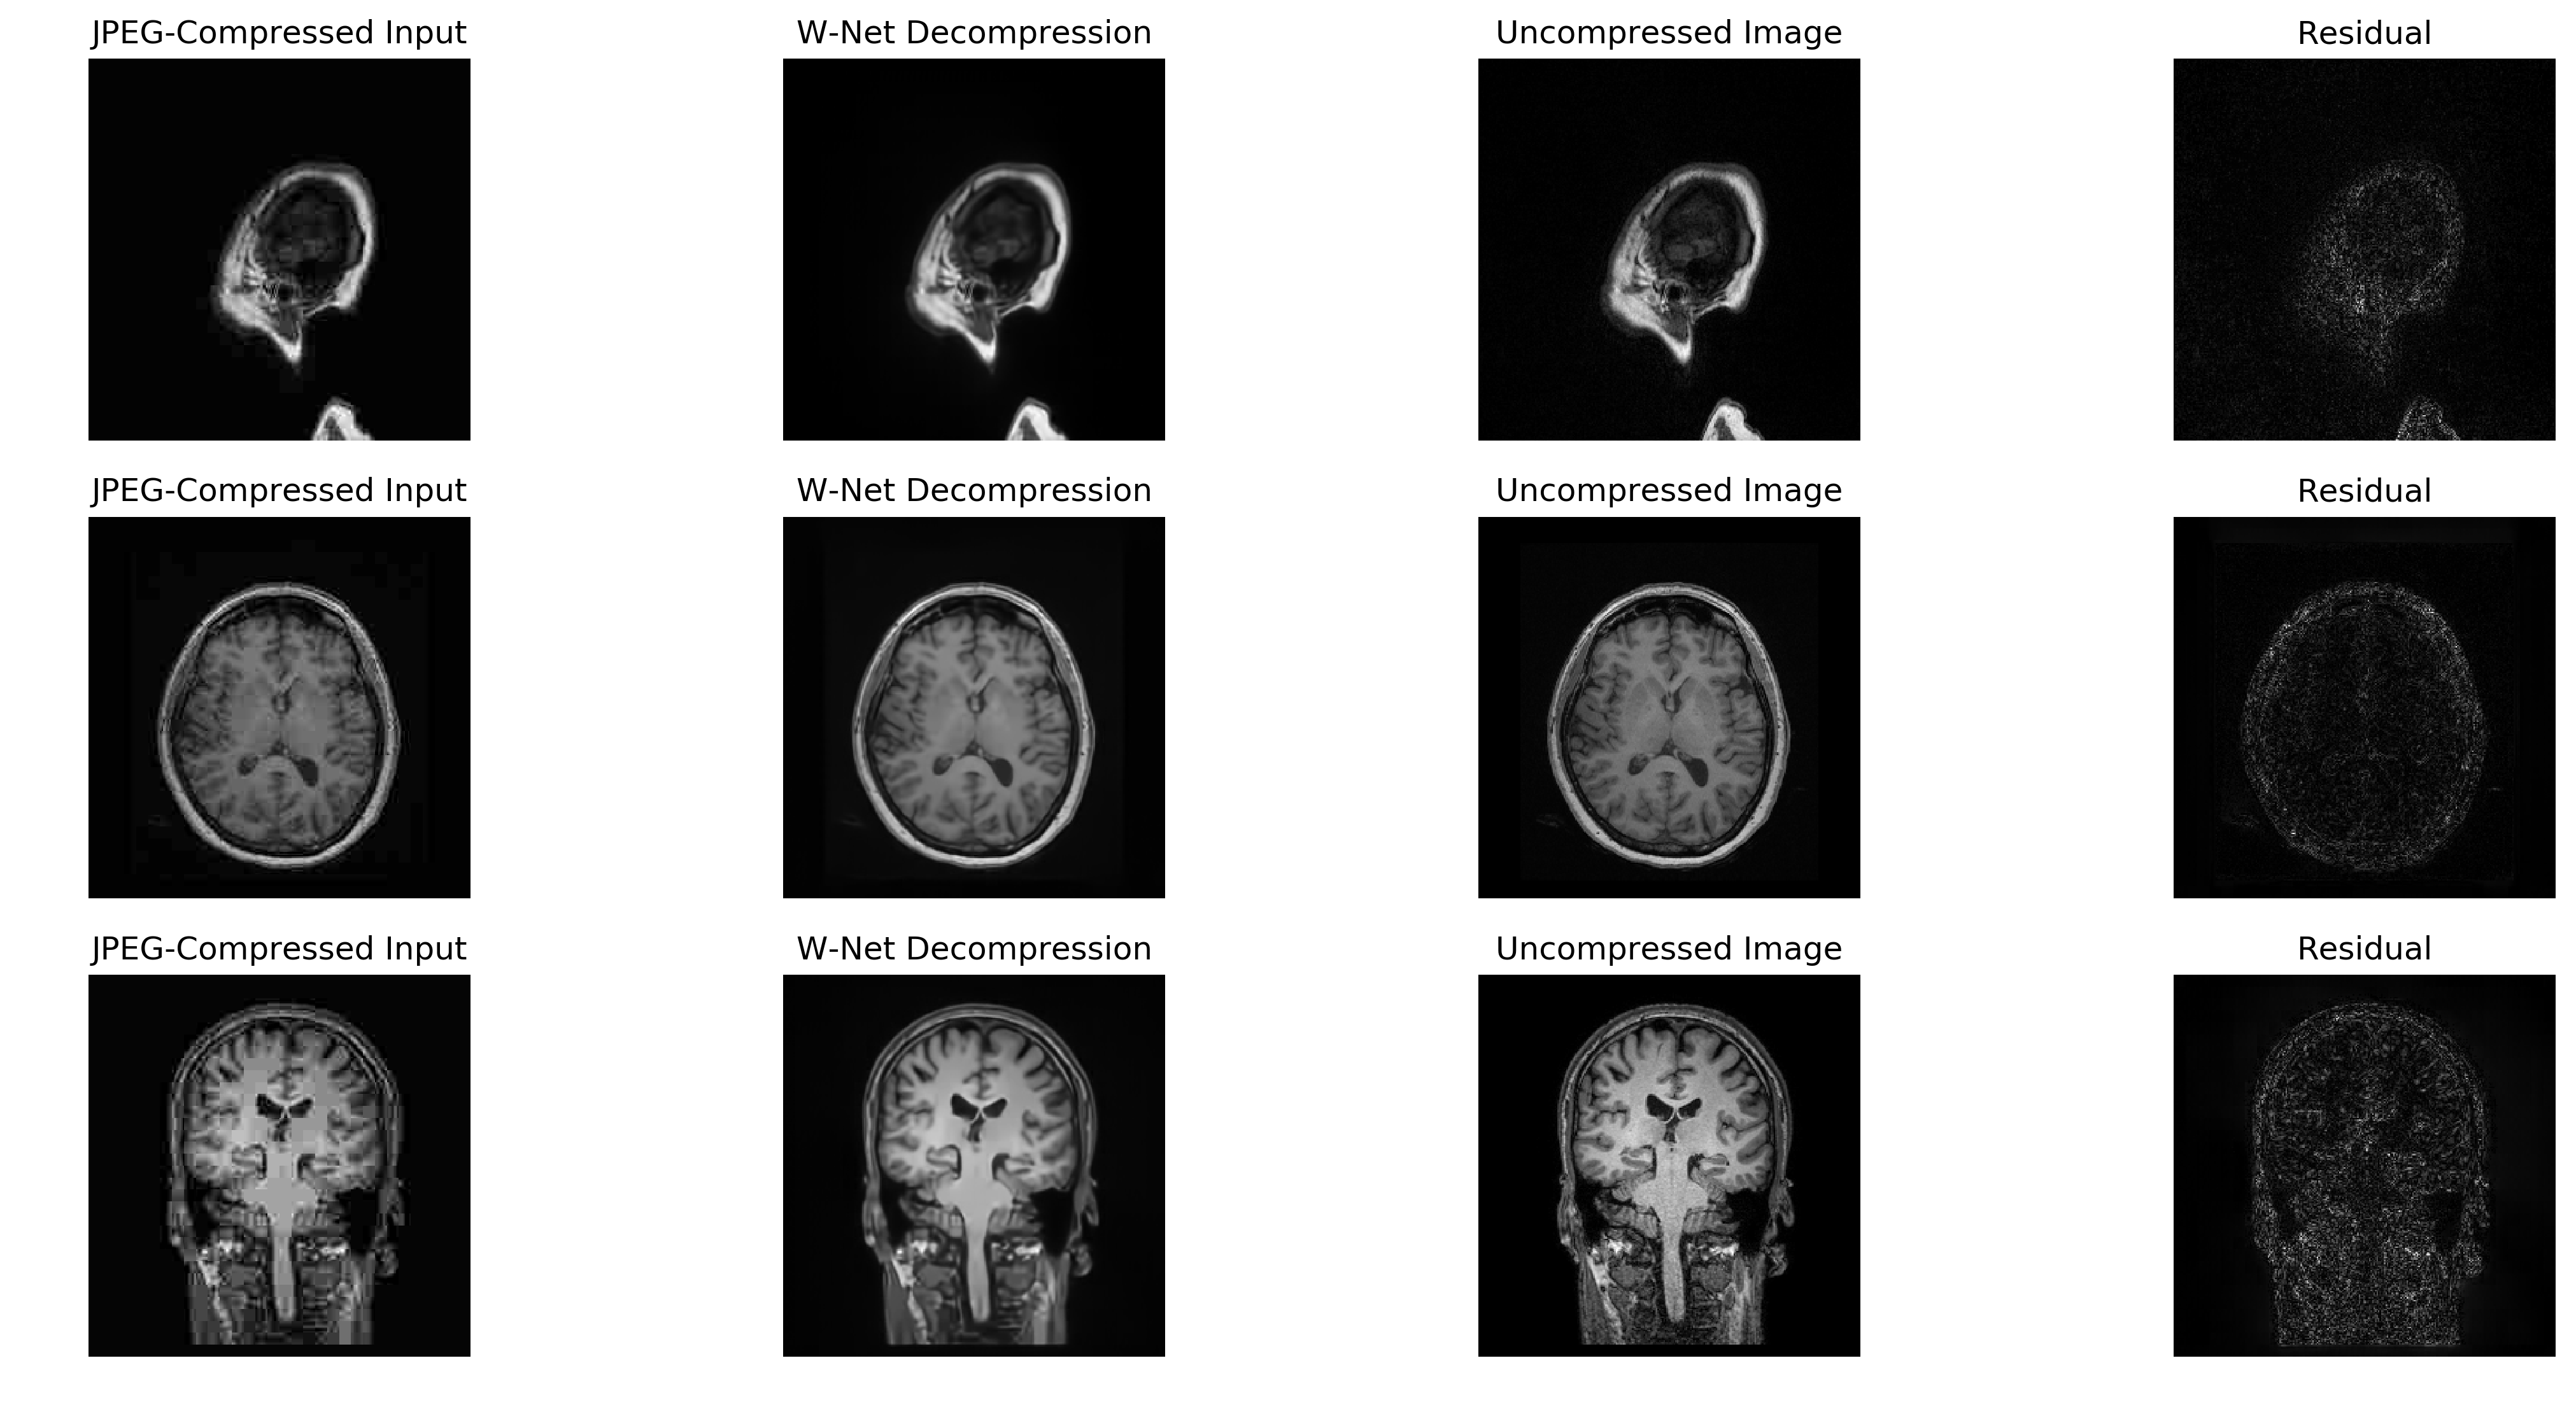

In [31]:
print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Input")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("W-Net Decompression")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0]-pred[indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

In [32]:
metr = calculate_metrics(test_unc, pred)

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


removing 1629 NRMSE from list.
removing 1715 NRMSE from list.
removing 1890 NRMSE from list.
removing 1896 NRMSE from list.
removing 3240 NRMSE from list.
removing 3514 NRMSE from list.
removing 3519 NRMSE from list.
(16103, 3, 2)

Performance Metrics
SSIM: 0.855 +/- 0.052
PSNR: 31.131 +/- 1.686
NRMSE: 2.707 +/- 0.479


In [33]:
# force stop "run all"
paoksdf += awew

NameError: name 'paoksdf' is not defined

In [ ]:
np.save("../np_imagedata/test_unc.npy",test_unc)
np.save("../np_imagedata/test_compr.npy",test_compr)


In [ ]:
! mkdir ../np_imagedata/20190328_test_results/qf10-20
np.save("../np_imagedata/20190328_test_results/qf10-20/net5_pred",pred)

In [ ]:
from scipy.io import savemat
from scipy.misc import imsave

im1 = Image.open(test_images[244])
im1_array = np.array(im1,dtype=np.float32)

buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=12)
im2 = Image.open(buffer)
im2_array = np.array(im2,dtype=np.float32)

im1_array -= 128.0
im1_array /= 128.0

im2_array -= 128.0
im2_array /= 128.0

dct1=dct_in_blocks(im1_array)
dct2=dct_in_blocks(im2_array)

# Display the images
plt.figure(figsize=(18,9))
plt.subplot(2,3,1)
plt.imshow(im1_array, cmap="gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(2,3,2)
plt.imshow(im2_array, cmap="gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.subplot(2,3,3)
plt.imshow(abs(im1_array - im2_array), cmap="gray")
plt.axis("off")
plt.title("Residual")
plt.subplot(2,3,4)
plt.imshow(dct1, cmap="gray", vmin=0, vmax=1/128.0)
plt.axis("off")
plt.subplot(2,3,5)
plt.imshow(dct2, cmap="gray", vmin=0, vmax=1/128.0)
plt.axis("off")
plt.subplot(2,3,6)
plt.imshow(abs(dct1 - dct2), cmap="gray", vmin=0, vmax=1/128.0)
plt.axis("off")
plt.show()

In [ ]:
opt=Adam(lr=0.0001)

model_name = "../Models/20190325-pretrained-residual_pseudo_wnet_di_data_augmentation_compress_10_20-float.hdf5"
model=deep_cascade_unet_no_dc(depth_str='i')


# model_name = "../Models/20190325-pretrained-residual_unet_d_data_augmentation_compress_10_20.hdf5"
# model=my_unet()





model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

In [ ]:
tens = np.zeros((1,256,256,1))
tens[0,:,:,0] = img_pred
#tens[0,:,:,0] = dct2

In [ ]:
tens_dct_pred = model.predict(tens)

# dct_pred = tens_dct_pred[0,:,:,0]
# img_pred = idct_in_blocks(dct_pred)

In [ ]:
plt.figure(figsize=(18,9),dpi=300)
plt.subplot(2,4,1)
plt.imshow(im1_array, cmap="gray")
plt.axis("off")
plt.title("Uncompressed Image")
plt.subplot(2,4,2)
plt.imshow(im2_array, cmap="gray")
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.subplot(2,4,3)
plt.imshow(img_pred, cmap="gray")
plt.axis("off")
plt.title("DCT U-net Prediction")
plt.subplot(2,4,4)
plt.imshow(abs(im1_array-img_pred), cmap="gray")
plt.axis("off")
plt.title("DCT Residual")
plt.subplot(2,4,5)
plt.imshow(dct1, cmap="gray",vmin=0,vmax=1/128.0)
plt.axis("off")
plt.title("Unquantized DCT Coefficients")
plt.subplot(2,4,6)
plt.imshow(dct2, cmap="gray",vmin=0,vmax=1/128.0)
plt.axis("off")
plt.title("Quantized DCT Coefficients")
plt.subplot(2,4,7)
plt.imshow(dct_pred, cmap="gray",vmin=0,vmax=1/128.0)
plt.axis("off")
plt.title("DCT U-net Prediction")
plt.subplot(2,4,8)
plt.imshow(abs(dct1-dct_pred), cmap="gray",vmin=0,vmax=1/128.0)
plt.axis("off")
plt.title("DCT Residual")
plt.show()

In [ ]:
test_unc = np.zeros((1,256,256,1))
test_compr = test_unc.copy()
tens_pred = test_unc.copy();

test_unc[0,:,:,0] = im1_array
test_compr[0,:,:,0] = im2_array
tens_pred[0,:,:,0] = img_pred

metrics = calculate_metrics(test_unc, test_compr, tens_pred)